# Stochastic Policy Optimization

This notebook is my progress right now in modeling stochastic policy optimization. It entails having a stochastic policy network class to model the policy, and necessary helper functions to step, rollout an episode, and calculate rewards. I am still working on tuning the implementation of this policy network, but yeah

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class StochasticPolicyNetwork:
    """
    A learnable stochastic linear policy for noisy environments.
    """
    def __init__(self, state_dim, action_dim, noise_std=0.1):
        self.weights = np.random.randn(action_dim, state_dim) * 0.1
        self.bias = np.zeros(action_dim)
        self.noise_std = noise_std
        self.lr = 5e-5  # Very small learning rate for stability

    def act(self, state):
        """
        Given a state, produce a stochastic action.
        """
        mean_action = self.weights @ state + self.bias
        action = mean_action + np.random.normal(0, self.noise_std, size=mean_action.shape)
        action = np.clip(action, -1.0, 1.0)  # Clip actions to avoid extreme moves
        return action, mean_action

    def update(self, states, actions, advantages):
        """
        Policy gradient update using REINFORCE.
        """
        for state, action, advantage in zip(states, actions, advantages):
            mean_action = self.weights @ state + self.bias
            grad_logp = (action - mean_action) / (self.noise_std ** 2)

            # Clip gradients to avoid exploding updates
            grad_logp = np.clip(grad_logp, -10, 10)

            # Gradient ascent step
            self.weights += self.lr * advantage * np.outer(grad_logp, state)
            self.bias += self.lr * advantage * grad_logp


In [3]:
def environment_step(state, action, noise_std=0.1): #Steps in environment while adding gaussian noise
    next_state = state + 0.1 * action + np.random.normal(0, noise_std, size=state.shape)
    return next_state

In [4]:
def rollout_episode(policy, initial_state, target, horizon=50): #A single episode
    state = initial_state
    states = []
    actions = []
    rewards = []

    for _ in range(horizon):
        action, mean_action = policy.act(state)
        next_state = environment_step(state, action)
        reward = -np.linalg.norm(next_state - target) ** 2  # Negative cost = reward

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state

    return np.array(states), np.array(actions), np.array(rewards)


In [5]:
def compute_reward(rewards, gamma=0.99): #Calculates rewards
    rtg = np.zeros_like(rewards)
    cumulative = 0
    for t in reversed(range(len(rewards))):
        cumulative = rewards[t] + gamma * cumulative
        rtg[t] = cumulative
    return rtg


In [6]:
def train_policy(policy, num_episodes=100, horizon=100): #Training loop
    target = np.zeros(2)
    episode_returns = []

    for episode in range(num_episodes):
        initial_state = np.random.randn(2)
        states, actions, rewards = rollout_episode(policy, initial_state, target, horizon)
        advantages = compute_reward(rewards)

        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8) #standardize advantages

        policy.update(states, actions, advantages)

        total_reward = np.sum(rewards)
        episode_returns.append(total_reward)

        if episode % 10 == 0:
            print(f"Episode {episode}: Total Reward {total_reward:.2f}")

    return episode_returns


Episode 0: Total Reward -252.78
Episode 10: Total Reward -115.65
Episode 20: Total Reward -248.49
Episode 30: Total Reward -156.38
Episode 40: Total Reward -181.45
Episode 50: Total Reward -1094.54
Episode 60: Total Reward -153.63
Episode 70: Total Reward -27.90
Episode 80: Total Reward -127.89
Episode 90: Total Reward -393.90
Episode 100: Total Reward -964.82
Episode 110: Total Reward -242.53
Episode 120: Total Reward -79.06
Episode 130: Total Reward -88.95
Episode 140: Total Reward -415.61
Episode 150: Total Reward -69.46
Episode 160: Total Reward -211.48
Episode 170: Total Reward -567.14
Episode 180: Total Reward -45.53
Episode 190: Total Reward -603.37


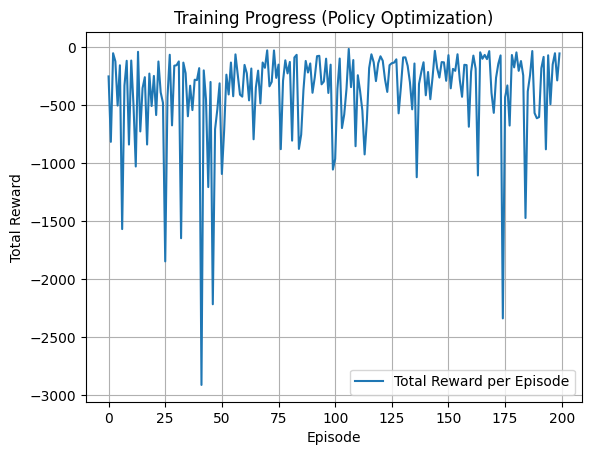

In [7]:
# Initialize the Policy
state_dim = 2
action_dim = 2
policy = StochasticPolicyNetwork(state_dim, action_dim)

# Train the Policy
returns = train_policy(policy, num_episodes=200)

plt.figure()
plt.plot(returns, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress (Policy Optimization)')
plt.legend()
plt.grid(True)
plt.show()

I am aware that there is still a lot of variability so far right now. I am still working on it